In [1]:
# import important libraries

import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the dataset

training_df_titanic = pd.read_csv('/kaggle/input/datasets-titanic-mukama/train.csv')

training_df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# test data
test_df_titanic = pd.read_csv('/kaggle/input/datasets-titanic-mukama/test.csv')
test_df_titanic.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# 1. About the dataset

In [4]:
# key info about dataset


# survival	Survival	0 = No, 1 = Yes
# pclass	Ticket class	1 = 1st(Upper), 2 = 2nd(Middle), 3 = 3rd(Lower)
# sex	Sex
# Age	Age in years
# sibsp	No. of siblings / spouses aboard the Titanic
# parch	No. of parents / children aboard the Titanic
# ticket	Ticket number
# fare	Passenger fare
# cabin	Cabin number
# embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [5]:
# shapes of datasets (train and test)

print("Shape of training dataset: ", training_df_titanic.shape)
print("Shape of test dataset: ", test_df_titanic.shape)

Shape of training dataset:  (891, 12)
Shape of test dataset:  (418, 11)


In [6]:
# Data types of the trainig dataset columns

print("Data types of the columns in training dataset: \n===============================================\n", training_df_titanic.dtypes)

Data types of the columns in training dataset: 
 PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [7]:
# Data types of the test dataset columns

print("Data types of the columns in test dataset: \n===============================================\n", test_df_titanic.dtypes)

Data types of the columns in test dataset: 
 PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


# 2. Identifying the missing Data

In [8]:
# Training dataset Missing values

training_missing_values = training_df_titanic.isnull().sum()
training_missing_values = training_missing_values[training_missing_values > 0]
print("Missing values in training dataset: \n=================================================\n", training_missing_values)


Missing values in training dataset: 
 Age         177
Cabin       687
Embarked      2
dtype: int64


In [9]:
# Testing dataset Missing values

testing_missing_values = test_df_titanic.isnull().sum()
testing_missing_values = testing_missing_values[testing_missing_values > 0]
print("Missing values in testing dataset: \n=================================================\n", testing_missing_values)

Missing values in testing dataset: 
 Age       86
Fare       1
Cabin    327
dtype: int64


# 3. Handling Missing Values

## 3.1. Handling Missing Values in Age column

In [10]:
import plotly.express as px

# Distribution of Age using Plotly
fig = px.histogram(training_df_titanic, x='Age', marginal='box', nbins=50, title='Distribution of Age in Training dataset')

# Display figure specifically for Kaggle
fig.show(renderer="iframe_connected")


In [11]:
fig = px.histogram(test_df_titanic, x='Age', marginal='box', nbins=50, title='Distribution of Age in Test Dataset')
fig.show(renderer="iframe_connected")

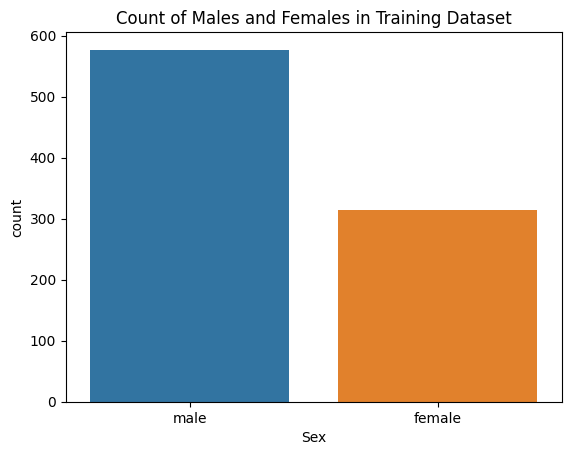

In [12]:
# count plot of the males and females
sns.countplot(x='Sex', data=training_df_titanic)
plt.title('Count of Males and Females in Training Dataset')
plt.show()

Text(0.5, 1.0, 'Count of Pclass in Training Dataset')

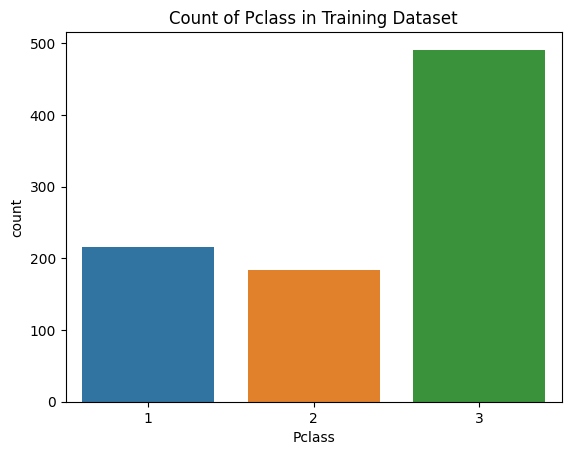

In [13]:
# count plot for pclass

sns.countplot(x='Pclass', data=training_df_titanic)
plt.title('Count of Pclass in Training Dataset')


- It is now important to fill missing value in Age column by their Median,due to skewness in distribution. 
- It is also important to fill ages based on gender and class.

In [14]:
# Define function to fill missing Age values based on Pclass and Sex median
def impute_age(df):
    for pclass in [1, 2, 3]:
        for sex in ['male', 'female']:
            median_age = df[(df['Pclass'] == pclass) & (df['Sex'] == sex)]['Age'].median()
            df.loc[(df['Age'].isnull()) & (df['Pclass'] == pclass) & (df['Sex'] == sex), 'Age'] = median_age

# Apply to both train and test sets
impute_age(training_df_titanic)
impute_age(test_df_titanic)

# Verify imputation
print("Missing Age values after imputation:\n", training_df_titanic['Age'].isnull().sum(), test_df_titanic['Age'].isnull().sum())


Missing Age values after imputation:
 0 0


**3.2. Handling Missing Values in Fare and Embarked columns**

In [15]:
training_df_titanic['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [16]:
# let's fill the missing values in Embarked column with the most frequent value
training_df_titanic['Embarked'].fillna(training_df_titanic['Embarked'].mode()[0], inplace=True)

In [17]:
# distribution of 'test_df_titanic['Fare']' using plotly
fig = px.histogram(test_df_titanic, x='Fare', marginal='box', nbins=50, title='Distribution of Fare in Test Dataset')
fig.show(renderer="iframe_connected")

In [18]:
# handling missing values in Fare column in test dataset
test_df_titanic['Fare'].fillna(test_df_titanic['Fare'].median(), inplace=True)

**3.3. Droping unnecessary Columns**

In [19]:
columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']

training_df_titanic.drop(columns=columns_to_drop,axis=1, inplace=True)
test_df_titanic.drop(columns=columns_to_drop,axis=1, inplace=True)

# 4. Encoding categorical columns

In [20]:
# encoding gender
training_df_titanic['Sex'] = training_df_titanic['Sex'].map({'male': 0, 'female': 1})
test_df_titanic['Sex'] = test_df_titanic['Sex'].map({'male': 0, 'female': 1})


In [21]:
# encoding Embarked

encoder= OneHotEncoder(sparse_output=False,handle_unknown='ignore')

training_encoded = pd.DataFrame(encoder.fit_transform(training_df_titanic[['Embarked']]))
test_encoded = pd.DataFrame(encoder.transform(test_df_titanic[['Embarked']]))
training_encoded.columns = encoder.get_feature_names_out(['Embarked'])
test_encoded.columns = encoder.get_feature_names_out(['Embarked'])

training_df_titanic.drop(columns=['Embarked'], inplace=True)
test_df_titanic.drop(columns=['Embarked'], inplace=True)


In [22]:

# concatenate the encoded columns to the training and test datasets
training_df_titanic = pd.concat([training_df_titanic, training_encoded], axis=1)
test_df_titanic = pd.concat([test_df_titanic, test_encoded], axis=1)

# 5. Fitting the model(s)

In [23]:
def best_classifier(X, y):
    # Scaling the training dataset
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Define models with hyperparameter grids
    classifiers = {
        'RandomForest': (RandomForestClassifier(), {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }),
        'GradientBoosting': (GradientBoostingClassifier(), {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5]
        }),
        'DecisionTree': (DecisionTreeClassifier(), {
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 5]
        }),
        'SVC': (SVC(), {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }),
        'KNeighbors': (KNeighborsClassifier(), {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }),
        'LogisticRegression': (LogisticRegression(), {
            'C': [0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'liblinear']
        }),
        'NaiveBayes': (GaussianNB(), {})  # No hyperparameters for Naive Bayes
    }

    results = []

    print("Training models...\n")

    # Train and evaluate each classifier
    for model_name, (classifier, param_grid) in classifiers.items():
        print(f'Training {model_name}...')
        
        if param_grid:
            grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
            model = grid_search.fit(X_scaled, y)
            best_params = model.best_params_
            best_model = model.best_estimator_
        else:
            best_model = classifier.fit(X_scaled, y)
            best_params = {}

        # Get the training accuracy
        train_accuracy = accuracy_score(y, best_model.predict(X_scaled))

        # Store the results
        results.append({
            'model': model_name,
            'parameters': best_params,
            'train_accuracy': train_accuracy,
            'best_model_instance': best_model
        })

        print(f'{model_name} Training Accuracy: {train_accuracy:.4f}')
        print(f'Best Parameters: {best_params}\n')

    # Sort by training accuracy and choose the best model
    results.sort(key=lambda x: x['train_accuracy'], reverse=True)
    best_model = results[0]['best_model_instance']

    print(f'\nBest Model: {results[0]["model"]}')
    print(f'Train Accuracy: {results[0]["train_accuracy"]:.4f}')
    print(f'Best Parameters: {results[0]["parameters"]}\n')

    return best_model, scaler


# Define target variable and features for training
y = training_df_titanic['Survived']
X = training_df_titanic.drop(columns=['Survived'], axis=1)

# Train the best classifier and get the scaler
best_model, scaler = best_classifier(X, y)


Training models...

Training RandomForest...
RandomForest Training Accuracy: 0.9203
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Training GradientBoosting...
GradientBoosting Training Accuracy: 0.9270
Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}

Training DecisionTree...
DecisionTree Training Accuracy: 0.9035
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}

Training SVC...
SVC Training Accuracy: 0.8451
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Training KNeighbors...
KNeighbors Training Accuracy: 0.8474
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}

Training LogisticRegression...
LogisticRegression Training Accuracy: 0.8081
Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}

Training NaiveBayes...
NaiveBayes Training Accuracy: 0.7868
Best Parameters: {}


Best Model: GradientBoosting
Train Accuracy

**Save the best model not to be changed**

In [24]:
# save the best model
import joblib
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Load the best model and scaler
loaded_model = joblib.load('best_model.pkl')
loaded_scaler = joblib.load('scaler.pkl')


In [25]:
# Scale the test dataset
X_test_scaled = loaded_scaler.transform(test_df_titanic)

# Make predictions
predictions = loaded_model.predict(X_test_scaled)

# Create a submission DataFrame
submission = pd.DataFrame({
    'PassengerId': pd.read_csv('/kaggle/input/datasets-titanic-mukama/test.csv')['PassengerId'],
    'Survived': predictions
})

# Save the submission DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)

In [26]:
# check the submission file
submission_df = pd.read_csv('submission.csv')
len(submission_df)

418